In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import os
import geopandas
import contextily as cx
import matplotlib.pyplot as plt
import pickle
from shapely.geometry import Polygon
from utils import *
from region import Region
import shapely.geometry
import pandas as pd
import json
from rasterio.windows import Window
import numpy as np
import rasterio
from lclu.constant import lcz_cmap, lcz_cmap2
import rioxarray
from rioxarray.merge import merge_arrays, merge_datasets
from geocube.api.core import make_geocube
import xarray

In [38]:
Ordu = pickle.load(open(os.path.join("data","Ordu_v1.pkl"),"rb"))
lcz_path = os.path.join ('data','lcz','lcz_filter_v1.tif')

In [192]:
Cairo = pickle.load(open(os.path.join("data","Cairo_v1.pkl"),"rb"))

In [39]:
ax = Ordu.house.plot(figsize=(18,14), )
cx.add_basemap(ax, crs="EPSG:4326")

In [294]:
df1 = Ordu.house.to_frame( name="geometry")
df1 = df1.to_crs("EPSG:3395")
df1["area"] = df1.to_crs("EPSG:3395").area
df1["density"] = 1
out_grid = make_geocube(
    vector_data=df1,
    measurements=["density","area"],
    # resolution=(-0.001, 0.001),
    resolution=(-2000,2000),
    fill=0,
    # output_crs = "EPSG:26717"
)

# out_grid.rio.to_raster("my_rasterized.tif")



In [304]:
out_grid.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int32 0
Attributes:
    crs_wkt:                            PROJCS["WGS 84 / World Mercator",GEOG...
    semi_major_axis:                    6378137.0
    semi_minor_axis:                    6356752.314245179
    inverse_flattening:                 298.257223563
    reference_ellipsoid_name:           WGS 84
    longitude_of_prime_meridian:        0.0
    prime_meridian_name:                Greenwich
    geographic_crs_name:                WGS 84
    horizontal_datum_name:              World Geodetic System 1984
    projected_crs_name:                 WGS 84 / World Mercator
    grid_mapping_name:                  mercator
    standard_parallel:                  0.0
    longitude_of_projection_origin:     0.0
    false_easting:                      0.0
    false_northing:                     0.0
    scale_factor_at_projection_origin:  1.0
    spatial_ref:                        PROJCS["WGS 84 / World Mercator",GEOG...
    GeoTransform:                       4214000.0 2000.0 0.0 4988000.0 0.0 -2...

In [253]:
out_grid = out_grid.rio.reproject("EPSG:4326")

In [302]:
out_grid.density.plot()

In [301]:
out_grid.area.plot()


In [270]:
out_grid.density.plot(cmap='pink')


In [193]:
df1 = Cairo.house.to_frame( name="geometry")
# df1 = df1.to_crs("EPSG:26717")
df1["area"] = df1.to_crs("EPSG:26717").area
df1["density"] = 1
df1
out_grid = make_geocube(
    vector_data=df1,
    measurements=["area"],
    resolution=(-0.0001, 0.0001),
    # resolution=(-100,100),
    fill=0,
)

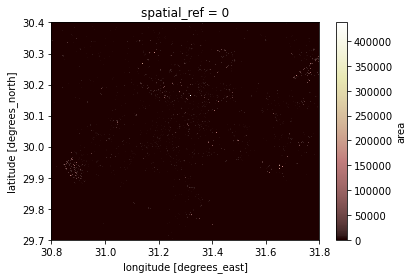

In [195]:
out_grid.area.plot(cmap='pink')

In [61]:
with rasterio.open("my_rasterized.tif") as src:
    crs = src.crs
    print(crs)
    print(src.descriptions)
    (lat_1, lon_1), (lat_2, lon_2) =Ordu.inner_box.box
    ax = rasterio.plot.show(src.read(1), cmap='pink', extent=( lon_1,lon_2, lat_2, lat_1), alpha=0.9)

EPSG:4326
('area',)


In [62]:
df = Ordu.inner_box.region
out_grid2 = make_geocube(
    vector_data=df,
    measurements=["population"],
    resolution=(-0.001, 0.001),
    # resolution=(-100,100),
    fill=0,
)
out_grid2.rio.to_raster("my_rasterized2.tif")


In [63]:
with rasterio.open("my_rasterized2.tif") as src:
    crs = src.crs
    print(crs)
    print(src.descriptions)
    (lat_1, lon_1), (lat_2, lon_2) =Ordu.inner_box.box
    ax = rasterio.plot.show(src.read(1), cmap='pink', extent=( lon_1,lon_2, lat_2, lat_1), alpha=0.9)

EPSG:4326
('population',)


In [271]:
(max_lat, min_lon), (min_lat, max_lon) = Ordu.inner_box.box
print((min_lat, min_lon), (max_lat, max_lon))
with rioxarray.open_rasterio(lcz_path) as src:
    print(src.attrs)
    print(src)
    lcz_grid = src.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
lcz_grid.plot( cmap=lcz_cmap)
# for im in ax.get_images():
#     im.set_clim(4, 17)
lcz_grid = lcz_grid.to_dataset(name="lcz")

(40.922495635935796, 37.859763930345395) (41.02005066750512, 38.03387755848272)
{'_FillValue': 0.0, 'scale_factor': 1.0, 'add_offset': 0.0}
<xarray.DataArray (band: 1, y: 155995, x: 389620)>
[649229756 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -170.0 -170.0 -170.0 -170.0 ... 180.0 180.0 180.0
  * y            (y) float64 80.04 80.04 80.04 80.03 ... -60.09 -60.09 -60.09
    spatial_ref  int32 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0


c:\Users\czhou\anaconda3\envs\wb39_1\lib\site-packages\rasterio\windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


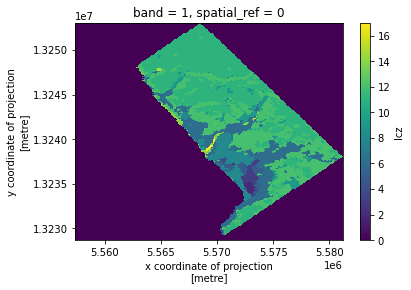

In [277]:
lcz_grid.rio.reproject("EPSG:26717").lcz.plot()
# lcz_grid.lcz.plot()

In [274]:
lcz_grid

<xarray.Dataset>
Dimensions:      (band: 1, x: 195, y: 110)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 37.86 37.86 37.86 37.86 ... 38.03 38.03 38.03 38.03
  * y            (y) float64 41.02 41.02 41.02 41.02 ... 40.92 40.92 40.92 40.92
    spatial_ref  int32 0
Data variables:
    lcz          (band, y, x) uint8 0 0 0 0 0 0 0 0 ... 11 11 11 11 11 11 11 11

In [240]:
x=lcz_grid.rio.reproject("EPSG:26717")
x.lcz.plot()
x

<xarray.Dataset>
Dimensions:      (x: 218, y: 223, band: 1)
Coordinates:
  * x            (x) float64 5.557e+06 5.558e+06 ... 5.581e+06 5.581e+06
  * y            (y) float64 1.325e+07 1.325e+07 ... 1.323e+07 1.323e+07
  * band         (band) int32 1
    spatial_ref  int32 0
Data variables:
    lcz          (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [241]:
x.rio.reproject("EPSG:4326").lcz.plot()

CPLE_AppDefinedError: Too many points (441 out of 441) failed to transform, unable to compute output bounds.

In [232]:
lcz_grid

<xarray.Dataset>
Dimensions:      (band: 1, x: 195, y: 110)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 37.86 37.86 37.86 37.86 ... 38.03 38.03 38.03 38.03
  * y            (y) float64 41.02 41.02 41.02 41.02 ... 40.92 40.92 40.92 40.92
    spatial_ref  int32 0
Data variables:
    lcz          (band, y, x) float32 nan nan nan nan ... 11.0 11.0 11.0 11.0

In [105]:
out_grid

<xarray.Dataset>
Dimensions:      (y: 937, x: 1376)
Coordinates:
  * y            (y) float64 41.02 41.02 41.02 41.02 ... 40.92 40.92 40.92 40.92
  * x            (x) float64 37.86 37.86 37.86 37.86 ... 38.0 38.0 38.0 38.0
    spatial_ref  int32 0
Data variables:
    area         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [106]:
out_grid2

<xarray.Dataset>
Dimensions:      (y: 95, x: 175)
Coordinates:
  * y            (y) float64 41.02 41.02 41.01 41.01 ... 40.93 40.92 40.92 40.92
  * x            (x) float64 37.86 37.86 37.86 37.86 ... 38.03 38.03 38.03 38.03
    spatial_ref  int32 0
Data variables:
    population   (y, x) float64 0.0 0.0 0.0 ... 8.221e+03 8.221e+03 8.221e+03

In [123]:
lcz_grid

<xarray.Dataset>
Dimensions:      (band: 1, x: 195, y: 110)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 37.86 37.86 37.86 37.86 ... 38.03 38.03 38.03 38.03
  * y            (y) float64 41.02 41.02 41.02 41.02 ... 40.92 40.92 40.92 40.92
    spatial_ref  int32 0
Data variables:
    lcz          (band, y, x) float32 nan nan nan nan ... 11.0 11.0 11.0 11.0

EPSG:4326
('population',)


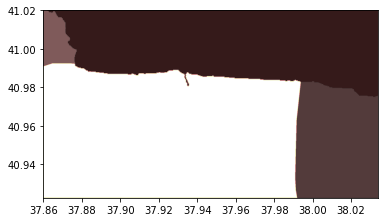

In [21]:
with rasterio.open("my_rasterized.tif") as src:
    crs = src.crs
    print(crs)
    print(src.descriptions)
    (lat_1, lon_1), (lat_2, lon_2) =Ordu.inner_box.box
    ax = rasterio.plot.show(src.read(1), cmap='pink', extent=( lon_1,lon_2, lat_2, lat_1), alpha=0.9)
    
    # ax = rasterio.plot.show(src.read(2), cmap='pink', extent=( lon_1,lon_2, lat_2, lat_1), alpha=0.9)
    # cx.add_basemap(ax, crs=crs)
    # plt.imshow(src.read_masks(1).T)
    

In [ ]:
with rasterio.open("my_rasterized.tif") as src:
    crs = src.crs
    print(crs)
    print(src)
    (lat_1, lon_1), (lat_2, lon_2) =Ordu.inner_box.box
    ax = rasterio.plot.show(src.read(1), cmap='pink', extent=( lon_1,lon_2, lat_2, lat_1), alpha=0.9)
    # cx.add_basemap(ax, crs=crs)
    
    ax = rasterio.plot.show(src.read(2), cmap='pink', extent=( lon_1,lon_2, lat_2, lat_1), alpha=0.9)
    # ax = rasterio.plot.show(src.read(2), cmap='pink', extent=( lon_1,lon_2, lat_2, lat_1), alpha=0.9)
    # cx.add_basemap(ax, crs=crs)
    # plt.imshow(src.read_masks(1).T)
    

In [62]:
(lat_1, lon_1), (lat_2, lon_2) = Ordu.inner_box.box

with rasterio.open(lcz_path) as src:
    crs = src.crs
    transformer = src.transform
    x_1, y_1 = ~transformer* (lon_1, lat_1)
    x_2, y_2 = ~transformer* (lon_2, lat_2)
    
    w = src.read(1, window=Window(x_1, y_1, x_2-x_1, y_2-y_1))
    bounds = ( lon_1,lon_2, lat_2, lat_1)

ax = rasterio.plot.show(w, extent=( lon_1,lon_2, lat_2, lat_1), cmap=lcz_cmap)
for im in ax.get_images():
    im.set_clim(1, 17)
cx.add_basemap(ax, crs=crs)

<Figure size 432x288 with 0 Axes>

In [289]:
lcz_grid.spatial_ref.attrs["crs_wkt"]

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

---

In [129]:
da = xarray.DataArray(
    np.sin(0.3 * np.arange(12).reshape(4, 3)),
    [("time", np.arange(4)), ("space", [0.1, 0.2, 0.3])],
)
da

<xarray.DataArray (time: 4, space: 3)>
array([[ 0.        ,  0.29552021,  0.56464247],
       [ 0.78332691,  0.93203909,  0.99749499],
       [ 0.97384763,  0.86320937,  0.67546318],
       [ 0.42737988,  0.14112001, -0.15774569]])
Coordinates:
  * time     (time) int32 0 1 2 3
  * space    (space) float64 0.1 0.2 0.3

In [130]:
da.sel(time=3)


<xarray.DataArray (space: 3)>
array([ 0.42737988,  0.14112001, -0.15774569])
Coordinates:
    time     int32 3
  * space    (space) float64 0.1 0.2 0.3

In [131]:
da.interp(time=2.5)

<xarray.DataArray (space: 3)>
array([0.70061376, 0.50216469, 0.25885874])
Coordinates:
  * space    (space) float64 0.1 0.2 0.3
    time     float64 2.5

In [160]:
lcz_grid.lcz.interp(x=out_grid.x, y=out_grid.y)

<xarray.DataArray 'lcz' (band: 1, y: 937, x: 1376)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, 12., ..., 11., 11., 11.],
        [nan, nan, 12., ..., 11., 11., 11.],
        [nan, nan, 12., ..., 11., 11., 11.]]])
Coordinates:
  * band         (band) int32 1
    spatial_ref  int32 0
  * x            (x) float64 37.86 37.86 37.86 37.86 ... 38.0 38.0 38.0 38.0
  * y            (y) float64 41.02 41.02 41.02 41.02 ... 40.92 40.92 40.92 40.92

In [184]:
out_grid = out_grid.assign(i1=lcz_grid.lcz.interp(x=out_grid.x, y=out_grid.y))
out_grid = out_grid.assign(i2=lcz_grid.lcz.interp_like(out_grid.area, method="nearest"))

In [293]:
lcz_grid.interp_like(out_grid, method="nearest")

<xarray.Dataset>
Dimensions:      (band: 1, y: 8, x: 8)
Coordinates:
  * band         (band) int32 1
    spatial_ref  int32 0
  * y            (y) float64 4.987e+06 4.985e+06 ... 4.975e+06 4.973e+06
  * x            (x) float64 4.215e+06 4.217e+06 ... 4.227e+06 4.229e+06
Data variables:
    lcz          (band, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [171]:
out_grid

<xarray.Dataset>
Dimensions:      (y: 937, x: 1376, band: 1)
Coordinates:
  * y            (y) float64 41.02 41.02 41.02 41.02 ... 40.92 40.92 40.92 40.92
  * x            (x) float64 37.86 37.86 37.86 37.86 ... 38.0 38.0 38.0 38.0
    spatial_ref  int32 0
  * band         (band) int32 1
Data variables:
    area         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    i1           (band, y, x) float64 nan nan nan nan ... 11.0 11.0 11.0 11.0
    i2           (band, y, x) float64 nan nan nan nan ... 11.0 11.0 11.0 11.0

(array([ 19261.,   1899., 171313.,      0., 101115.,      0., 564853.,
             0.,   9585.,   2070.]),
 array([ 2. ,  3.5,  5. ,  6.5,  8. ,  9.5, 11. , 12.5, 14. , 15.5, 17. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

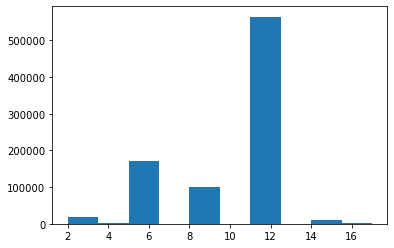

In [185]:
plt.hist(out_grid.i2.data.flatten())

In [187]:
print(np.unique(lcz_grid.lcz.data))
print(np.unique(out_grid.i2.data))


[ 2.  3.  4.  5.  6.  8.  9. 11. 12. 14. 15. 16. 17. nan]
[ 2.  3.  4.  5.  6.  8.  9. 11. 12. 14. 17. nan]


In [190]:
out_grid.i2.plot()

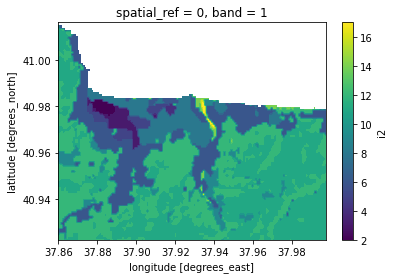

In [170]:
out_grid.i2.plot()


In [158]:
lcz_grid

<xarray.Dataset>
Dimensions:      (band: 1, x: 195, y: 110)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 37.86 37.86 37.86 37.86 ... 38.03 38.03 38.03 38.03
  * y            (y) float64 41.02 41.02 41.02 41.02 ... 40.92 40.92 40.92 40.92
    spatial_ref  int32 0
Data variables:
    lcz          (band, y, x) float32 nan nan nan nan ... 11.0 11.0 11.0 11.0

In [159]:
out_grid

<xarray.Dataset>
Dimensions:      (y: 937, x: 1376)
Coordinates:
  * y            (y) float64 41.02 41.02 41.02 41.02 ... 40.92 40.92 40.92 40.92
  * x            (x) float64 37.86 37.86 37.86 37.86 ... 38.0 38.0 38.0 38.0
    spatial_ref  int32 0
Data variables:
    area         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [306]:
dump_path = os.path.join("data","Cities_v1.pickle")

with open(dump_path, 'rb') as f:
    Cities = pickle.load(f)
    
ax = Cities["Ordu"].vector["MS"].geo_df.plot(zorder=999,)
Cities["Ordu"].raster["census_raster_100"].tiff.population.plot(cmap="pink", ax=ax)